In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ventura/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ventura/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/ventura/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <B36C132B-E822-3FDA-9BEC-DD9DB8197D06> /Users/ventura/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Neural network class

In [3]:
class NeuralNetwork(nn.Module):
    """
    A Convolutional Neural Network (CNN) for MNIST digit classification.

    This model takes a 28x28 grayscale image as input and classifies it into
    one of the 10 digit classes (0-9).
    """
    def __init__(self):
        """
        Initializes the MNISTModel with the following layers:
        - Two convolutional layers with max pooling and ReLU activation.
        - A flattening layer.
        - A fully connected layer.
        """
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 10) containing
            the predicted class scores for each digit.
        """
        logits = self.linear_relu_stack(x)
        return logits

### Dataset

In [4]:
transform = transforms.Compose(
  [
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5,), (0.5,))
  ]
)

training_data = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
validation_data = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

### Understand the dataset

Total number of samples: 60000
Shape of a single data sample: torch.Size([1, 28, 28])
Type of data:  <class 'torch.Tensor'>
Type of label: <class 'int'>


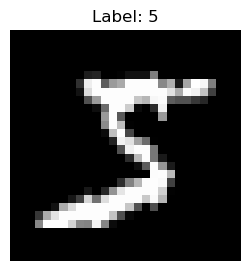

In [5]:
def explore_dataset(data):
    """
    Helps familiarize with the MNIST dataset. 
    Prints the size of the dataset, its shape, format, and plots a sample.
    """
    # Display the length of the training dataset
    print("Total number of samples:", len(data))

    # Display the shape of a single sample
    sample_data, sample_label = data[0]
    print("Shape of a single data sample:", sample_data.shape)
    print("Type of data: ", type(sample_data))
    print("Type of label:", type(sample_label))

    # Plot the images in the batch
    def show_image(image, label):
        plt.figure(figsize=(3, 3))
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

    # Display the first image and label in the batch
    show_image(sample_data, sample_label)

explore_dataset(training_data)

### Training 

In [6]:
model = NeuralNetwork().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3

start_time = time.time()

for _ in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)

        # One-hot encoding
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        # Implements sigmoid function to the output and computes the cross-entropy loss function
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch {_}, batch {i}, loss: {loss.item()}")

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0, batch 0, loss: 0.7050976753234863
Epoch 0, batch 100, loss: 0.17783868312835693
Epoch 0, batch 200, loss: 0.13471470773220062
Epoch 0, batch 300, loss: 0.10054139047861099
Epoch 0, batch 400, loss: 0.1030053123831749
Epoch 0, batch 500, loss: 0.08426903933286667
Epoch 0, batch 600, loss: 0.06904156506061554
Epoch 0, batch 700, loss: 0.0973028838634491
Epoch 0, batch 800, loss: 0.05411010980606079
Epoch 0, batch 900, loss: 0.06396054476499557
Epoch 1, batch 0, loss: 0.07114696502685547
Epoch 1, batch 100, loss: 0.06155892089009285
Epoch 1, batch 200, loss: 0.05961950495839119
Epoch 1, batch 300, loss: 0.04896778613328934
Epoch 1, batch 400, loss: 0.04132036492228508
Epoch 1, batch 500, loss: 0.029348503798246384
Epoch 1, batch 600, loss: 0.022657016292214394
Epoch 1, batch 700, loss: 0.028647279366850853
Epoch 1, batch 800, loss: 0.06098712608218193
Epoch 1, batch 900, loss: 0.02580675110220909
Epoch 2, batch 0, loss: 0.04519150033593178
Epoch 2, batch 100, loss: 0.021948877722

### Model eval

In [7]:
def eval_model(data, loader):
    """
    Evaluates the MNIST model on the validation/test dataset. 
    Computes and prints the model's accuracy and the macro-average of the precision, recall and
    f1-score. 

    Args:
        data: The  validation/test data.
        loader: DataLoader for the validation/test dataset.
    """
    model.to(device)
    true = 0
    true_positive = torch.zeros(10)
    false_positive = torch.zeros(10)
    pos = torch.zeros(10)

    dataset_size = len(data)
    for (images, labels) in loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        predictions = torch.argmax(output, dim=1)
        true += torch.sum(predictions == labels).item()

        for cls in range(10):
            true_positive[cls] += ((predictions == cls) & (labels == cls)).sum().item()
            false_positive[cls] += ((predictions == cls) & (labels != cls)).sum().item()
            pos[cls] += (labels == cls).sum().item()

    # Compute accuracy, precision, recall and f1_score
    accuracy = true / dataset_size
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / pos
    f1_score = 2 * precision * recall / (precision + recall)

    # Accuracy
    print(f"Accuracy: {accuracy}")

    # Macro-Average
    print("Macro-Average")
    print(f"Precision: {precision.sum() / 10}")
    print(f"Recall: {recall.sum() / 10}")
    print(f"F1 Score: {f1_score.sum() / 10}")

eval_model(validation_data, validation_loader)

Accuracy: 0.9635
Macro-Average
Precision: 0.9635518789291382
Recall: 0.9633437991142273
F1 Score: 0.9633414149284363


## Test the model with custom images

### Load the test dataset

In [8]:
test_data = ImageFolder(root="data/test-images", transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### Explore test data

Total number of samples: 40
Shape of a single data sample: torch.Size([1, 28, 28])
Type of data:  <class 'torch.Tensor'>
Type of label: <class 'int'>


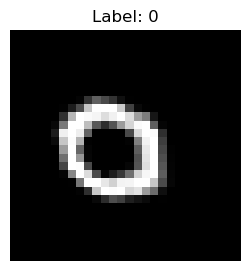

In [9]:
explore_dataset(test_data)

### Model Test

In [10]:
eval_model(test_data, test_loader)

Accuracy: 0.875
Macro-Average
Precision: 0.9133332967758179
Recall: 0.875
F1 Score: 0.8726984858512878


### Save model

In [11]:
torch.save(model.state_dict(), "MNISTclassifier_data_augment.pth")

In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("MNISTclassifier_data_augment.pth", weights_only=True, map_location=device))

<All keys matched successfully>

In [13]:
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

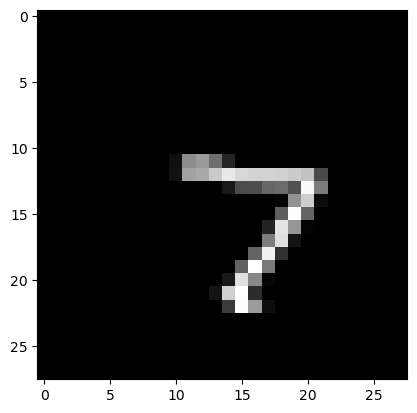

In [14]:
image, label = validation_data[0]
plt.imshow(image[0], cmap='gray')

In [15]:
image = image.to(device)

# Make the tensor 4D (batched)
if image.dim() == 3:
  image = image.unsqueeze(0)

output = model(image)
m = nn.Softmax(dim=1)
output = m(output)

In [16]:
output.cpu().detach().numpy().argmax()

7

## GUI

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

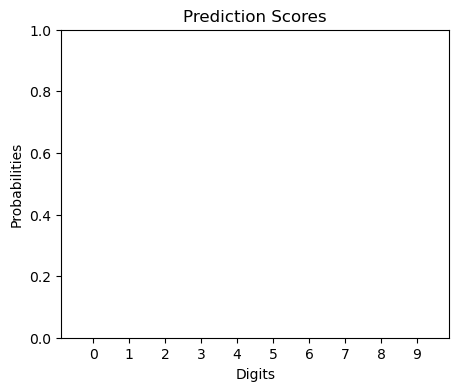

In [17]:
import tkinter as tk
from tkinter import Canvas, messagebox, simpledialog
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os

transform = transforms.Compose(
  [
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]
)

digit_images = {}
for img, label in training_data:
    if label not in digit_images:
        digit_images[label] = img
    if len(digit_images) == 10:
        break

class DigitClassifierGUI:
    """
    A Graphical User Interface (GUI) for MNIST digit classification using a pre-trained model.

    This GUI allows the user to write a digit, and predict it using the trained model.
    """
    def __init__(self, root):
        """
        Initializes the GUI class and sets up the GUI components.

        Args:
            root (tk.Tk): The root window for the tkinter GUI.
        """
        self.root = root
        self.root.title("MNIST Digit Classifier")
        self.size = 400
        # Flag to track if the canvas has been modified
        self.canvas_modified = False

        self.false = 0
        self.counter = 0

        self.result_label = tk.Label(
            self.root, 
            text="Draw a digit from 0 to 9", 
            font=("Helvetica", 24)
        )
        self.result_label.grid(row=0, column=0, columnspan=5, pady=(10, 0))

        # Create a Canvas for drawing
        self.canvas = Canvas(self.root, width=self.size, height=self.size, bg="white")
        self.canvas.grid(row=1, column=0, columnspan=5, padx=50, pady=(0, 10))
        
        # Set up for drawing
        self.image = Image.new("L", (self.size, self.size), "white")
        self.draw = ImageDraw.Draw(self.image)
        self.canvas.bind("<B1-Motion>", self.paint)

        # Predict button
        self.predict_button = tk.Button(self.root, text="Predict", command=self.predict_digit)
        self.predict_button.grid(row=2, column=1)
        
        # Reset button
        self.reset_button = tk.Button(self.root, text="Reset", command=self.reset_canvas)
        self.reset_button.grid(row=2, column=3)

        # Set up plot area for prediction results
        self.figure, self.ax = plt.subplots(figsize=(5, 4))
        self.init_plot()
        self.plot_canvas = FigureCanvasTkAgg(self.figure, self.root)
        self.plot_canvas.get_tk_widget().grid(row=1, column=5, columnspan=5)

        # Display MNIST digit images
        self.digit_labels = []
        for i in range(10):
            img_array = digit_images[i].numpy().squeeze() * 255  # Convert to numpy and scale
            img = Image.fromarray(img_array).resize((100, 100), Image.ANTIALIAS)
            img_tk = ImageTk.PhotoImage(img)

            label = tk.Label(self.root, image=img_tk, bg="white", relief="raised")
            label.image = img_tk  # Keep a reference to prevent garbage collection
            label.grid(row=4, column=i, columnspan=1, padx=(28, 0), pady=20)
            self.digit_labels.append(label)
        
        # Accuracy display
        self.accuracy_label = tk.Label(
            self.root, 
            text="Accuracy: No predictions made yet.", 
            font=("Helvetica", 14)
        )
        self.accuracy_label.grid(row=5, column=0, columnspan=5 ,pady=5)

    def paint(self, event):
        """
        Allows the user to paint a digit
        """
        thickness = 13
        x1, y1 = (event.x - thickness), (event.y - thickness)
        x2, y2 = (event.x + thickness), (event.y + thickness)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black", outline="black", width=5)
        self.draw.ellipse([x1, y1, x2, y2], fill="black")
        self.canvas_modified = True  # Mark the canvas as modified

    def init_plot(self):
        self.ax.set_title("Prediction Scores")
        self.ax.bar(range(10), np.zeros(10))
        self.ax.set_ylim([0, 1])
        self.ax.set_xticks(range(10))
        self.ax.set_xlabel("Digits")
        self.ax.set_ylabel("Probabilities")

    def reset_canvas(self):
        """
        Clears the canvas where the user can re-write another digit.
        """
        self.canvas.delete("all")
        self.draw.rectangle([0, 0, self.size, self.size], fill="white")
        self.ax.clear()
        self.init_plot()
        self.plot_canvas.draw()
        self.reset_highlight()
        self.canvas_modified = False  # Reset the modification flag

    def predict_digit(self):
        """
        Predicts the handwritten digit using the pre-trained model and updates the result label.
        """
        if not self.canvas_modified:
            messagebox.showwarning("Empty Canvas", "Please draw a number.")
            return

        # Resize and process the image to be 28x28 for MNIST model
        image_tensor = transform(self.image).unsqueeze(0)*(-1)
        
        # Run the image through the model
        with torch.no_grad():
            predictions = model(image_tensor)
            m = nn.Softmax(dim=1)
            predictions = m(predictions)

        predicted_label = torch.argmax(predictions).item()
        # Update the plot
        self.ax.clear()
        self.ax.bar(range(10), predictions.numpy()[0])
        self.ax.set_ylim([0, 1])
        self.ax.set_xticks(range(10))
        self.ax.set_xlabel("Digits")
        self.ax.set_ylabel("Probabilities")
        self.ax.set_title(f"Prediction: {predicted_label}")
        self.plot_canvas.draw()

        self.highlight_digit(predicted_label)
        self.confirm_prediction(predicted_label)

    def reset_highlight(self):
        """
        Reset the highlight for all digit labels.
        """
        for label in self.digit_labels:
            label.config(bg="white", highlightthickness=0, relief="raised")

    def highlight_digit(self, digit):
        """
        Highlight the predicted digit.
        """
        self.reset_highlight()
        self.digit_labels[digit].config(
            highlightbackground="green",
            highlightthickness=5, 
            relief="solid"
        )

    def confirm_prediction(self, digit):
        """
        Checks if the predicted label is correct.
        """
        response = messagebox.askyesno("Confirm Prediction", f"Is the predicted digit '{digit}' correct?")
        if not response:
            self.false += 1
            # Prompt the user to enter the correct digit
            corrected_digit = simpledialog.askinteger("Correct Prediction", "Enter the correct digit:")
            # Store (image, corrected_digit) for future training
            self.save_correction(corrected_digit)
        self.counter += 1
        self.reset_canvas()
        accuracy = (self.counter - self.false) * 100 / self.counter
        self.accuracy_label.config(text=f"Accuracy: {accuracy:.2f}%")

    def save_correction(self, corrected_digit):
        """
        Save the drawn image and corrected label to a dataset
        """
        # Create a unique filename for the image
        image_count = len(os.listdir("data/ai-day-test-images"))  # Number of files already in the directory
        image_filename = os.path.join("data/ai-day-test-images", f"digit_{image_count}.png")

        self.image.save(image_filename)
        print(f"Image saved to {image_filename}")

        # Save the label to a CSV file
        labels_file = os.path.join("data/ai-day-test-images", "labels.csv")
        with open(labels_file, "a") as file:
            file.write(f"{image_filename},{corrected_digit}\n")
        print(f"Label saved to {labels_file}")

# Create the Tkinter window
root = tk.Tk()
root.geometry("1920x1080")
app = DigitClassifierGUI(root) 
root.mainloop()


In [19]:
import torch.onnx

# Export the model to ONNX format
dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "model.onnx",
                 input_names=['input'],
                 output_names=['output'],
                 dynamic_axes={'input': {0: 'batch_size'},
                             'output': {0: 'batch_size'}})